In [49]:
# import sys
# print(sys.executable)
# print(sys.version)

import os
os.environ['PROJ_LIB'] = '/home/jlee/.conda/envs/mmc_sgp/share/proj'

import wrf
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import xarray as xr
from numba import njit

wrf_runs_dir = '/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/'
nb_dir = !pwd
data_dir_df = pd.read_csv(nb_dir[0]+'/data-dir-j3leswrf.csv', index_col=0)
plots_dir = nb_dir[0]+'/plots_05a'

# get specific dates associated w/ wrf runs
data_dir_df = pd.read_csv(nb_dir[0]+'/data-dir-j3leswrf.csv', index_col=0)

runs_list = list(data_dir_df.index)[:-1]

In [50]:
data_dir_df

,2018-08-05,2018-09-01
mynn,a1_0805m_30s,o1_0901m_30s
mynn_ck0.1,l7_0805m-ck,NaN
edmf,a2_0805e_30s,o2_0901e_30s
mynn_all4d-1arcs-topo,l5_0805m,NaN
mynn_d12-9s_d34-1s,a5_0805m_9s1s,o5_0901m_9s1s
mynn_d123-9s_d4-1s_lu,n2_d123-9s_d4-1s,NaN
mynn_all4d-9arcs_lu,n3_9s,NaN
edmf_d12-9s_d34-1s,a6_0805e_9s1s,o6_0901e_9s1s
wrf_start,8/4/18 12:00,8/31/18 12:00


In [77]:
def detect_auxout_edmf_d02_plot_d04(eval_date, run, edmf_var, hgt_i):

    # eval_date = '2018-09-01'
    # run = 'edmf'

    date_col = data_dir_df[eval_date]

    # hr = 20
    activation_t = 0
    tstamp_list = []

    for ind, hr in enumerate(np.arange(16, 24, 1)): 

        file = wrf_runs_dir+date_col[run]+'/auxout/mmc_d02_'+eval_date+'_'+str(hr)+':00:00'
        wrf_single = Dataset(file, 'r')

        var = wrf.getvar(wrf_single, edmf_var, timeidx=wrf.ALL_TIMES)

        # d04 grid cells in d02
        var_w = var[:, :, 121:126, 119:123]

    #     print(hr,'UTC')

        for t in np.arange(0, 6): 

            if (var_w[t, hgt_i, :, :] != 0).sum().values != 0:
                
                activation_t += 1

#                 hgt_i = 16

    #             print(var_w[t, :, :, :].Time.values)
    #             print((var_w[t, hgt_i, :, :] != 0).sum().values)

                height = wrf.getvar(wrf_single, 'height_agl').mean(dim=['south_north', 'west_east'])[hgt_i]
                height_str = str(int(height.values))

    #             print(height_str)

                lats, lons = wrf.latlon_coords(var_w)

                fig, ax = plt.subplots()#figsize=(8, 8))

                var_1time1hgt = var_w[t, hgt_i, :, :]

                bm = wrf.get_basemap(var_1time1hgt, ax=ax)

                bm.drawparallels(np.arange(36, 37, 0.05), labels=[1, 0, 0, 0])
                bm.drawmeridians(np.arange(-98, -97, 0.05), labels=[0, 0, 0, 1])

                x, y = bm(wrf.to_np(lons), wrf.to_np(lats))

                p = bm.contourf(x, y, wrf.to_np(var_1time1hgt), cmap=get_cmap('viridis'), 
                                levels=len(np.unique(var_1time1hgt.values)))

    #             print(np.unique(var_1time1hgt.values))
                tstamp = pd.Timestamp(var_w[t, :, :, :].Time.values)
                tstamp_list.append(str(tstamp.hour)+':'+str(tstamp.minute))

                ax.set_title(str(tstamp)+'\n'+var_1time1hgt.description+' @ '+height_str+' m\n'
                             +str((var_w[t, hgt_i, :, :] != 0).sum().values)+' d02 meso grid cells activated')

                c1x, c1y = bm(wrf.to_np(-97.487643), wrf.to_np(36.607322))
                bm.scatter(c1x, c1y, s=200, marker='x', color='white', linewidth=4, ax=ax)

                c1x, c1y = bm(wrf.to_np(-97.493), wrf.to_np(36.595))
                ax.annotate('C1', xy=(c1x, c1y), size=15, color='white')

                cax = plt.axes([0.25, 0.01, 0.5, 0.04])
                sm = plt.cm.ScalarMappable(cmap='viridis', 
                                           norm=plt.Normalize(vmin=var_1time1hgt.min(), vmax=var_1time1hgt.max()))
                cb = plt.colorbar(sm, cax=cax, orientation='horizontal')

                plt.show()
                
    print('a total of', activation_t, 'time steps w/ EDMF turned on in d02, they are:')
    print(tstamp_list)

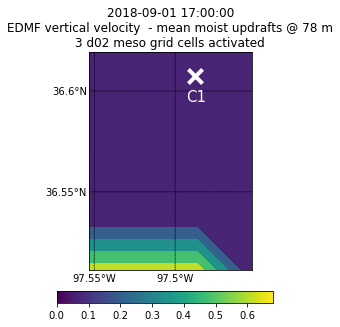

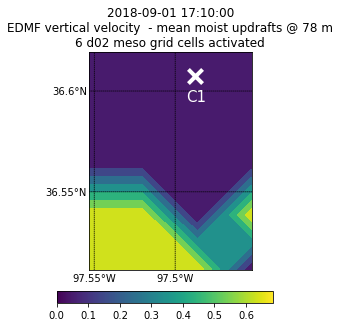

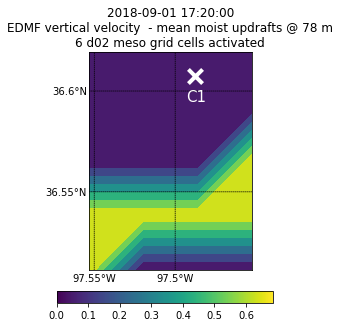

a total of 3 time steps w/ EDMF turned on in d02, they are:
['17:0', '17:10', '17:20']


In [78]:
eval_date = '2018-09-01'
run = 'edmf'
edmf_var = 'EDMF_W'
hgt_i = 16

detect_auxout_edmf_d02_plot_d04(eval_date, run, edmf_var, hgt_i)

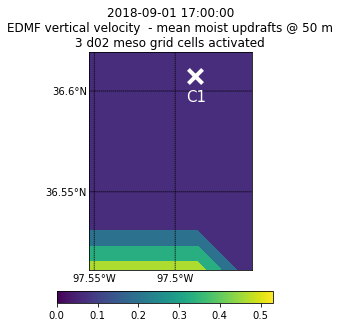

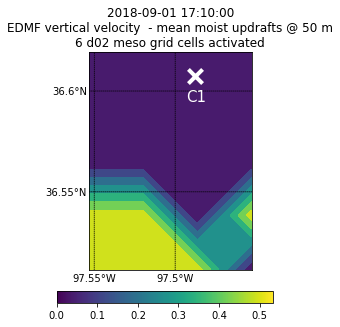

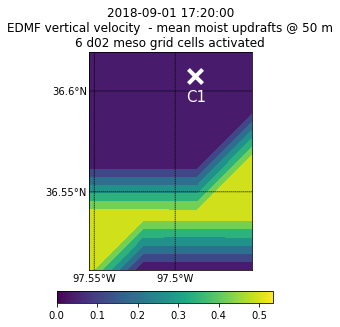

a total of 3 time steps w/ EDMF turned on in d02


In [62]:
eval_date = '2018-09-01'
run = 'edmf'
edmf_var = 'EDMF_W'
hgt_i = 10

detect_auxout_edmf_d02_plot_d04(eval_date, run, edmf_var, hgt_i)

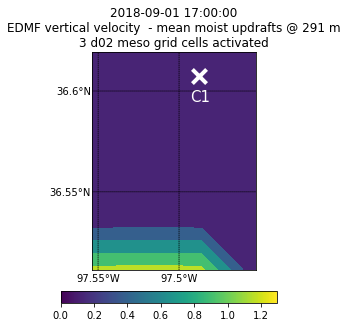

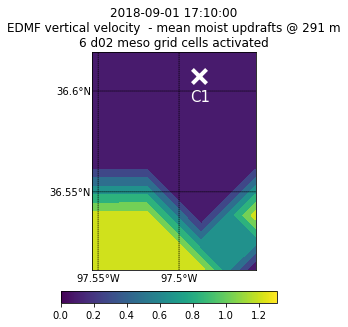

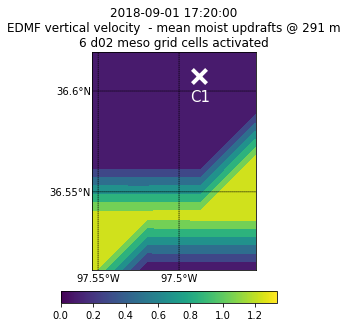

a total of 3 time steps w/ EDMF turned on in d02


In [64]:
eval_date = '2018-09-01'
run = 'edmf'
edmf_var = 'EDMF_W'
hgt_i = 40

detect_auxout_edmf_d02_plot_d04(eval_date, run, edmf_var, hgt_i)

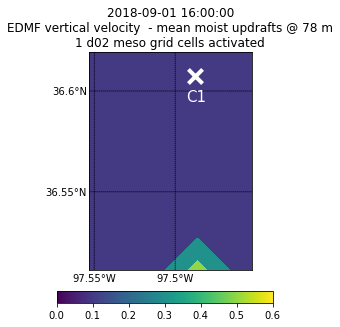

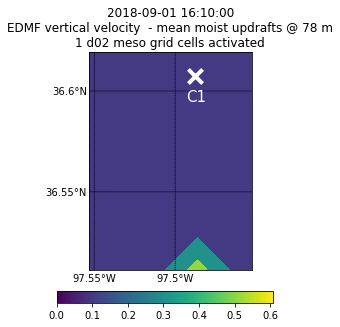

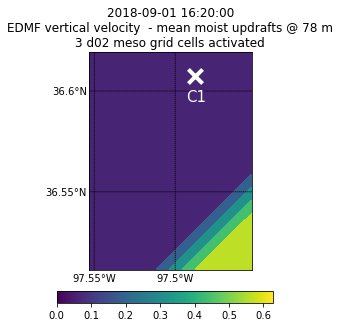

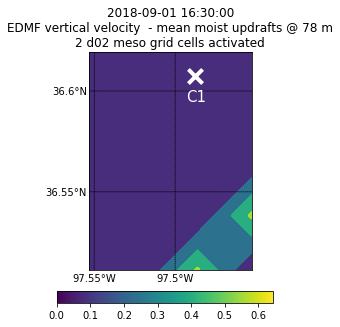

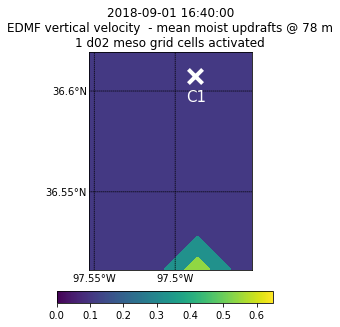

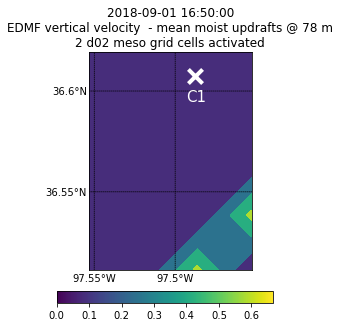

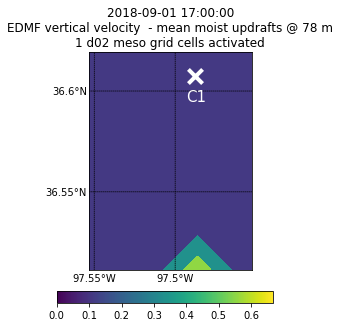

a total of 7 time steps w/ EDMF turned on in d02, they are:
['16:0', '16:10', '16:20', '16:30', '16:40', '16:50', '17:0']


In [81]:
eval_date = '2018-09-01'
run = 'edmf_d12-9s_d34-1s'
edmf_var = 'EDMF_W'
hgt_i = 16

detect_auxout_edmf_d02_plot_d04(eval_date, run, edmf_var, hgt_i)

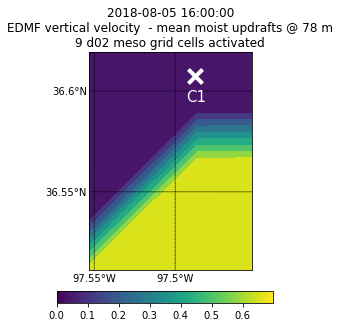

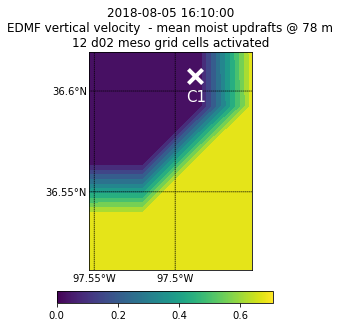

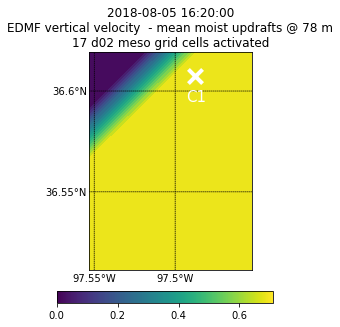

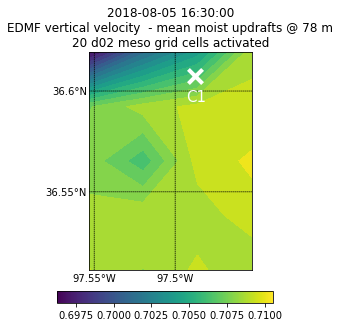

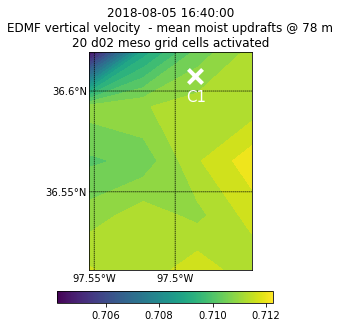

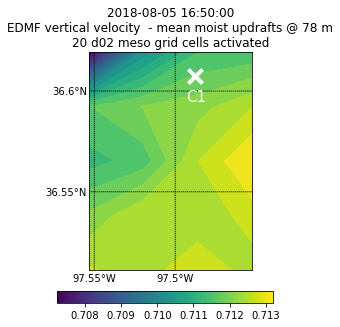

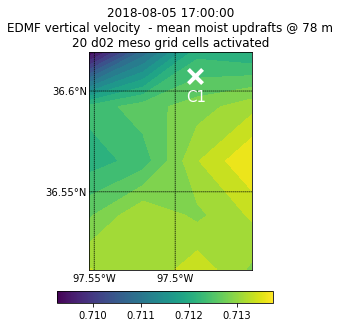

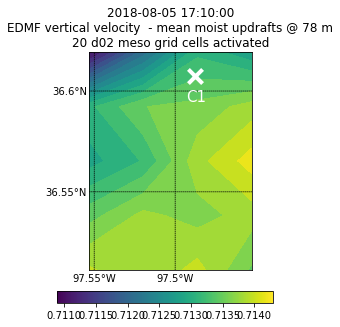

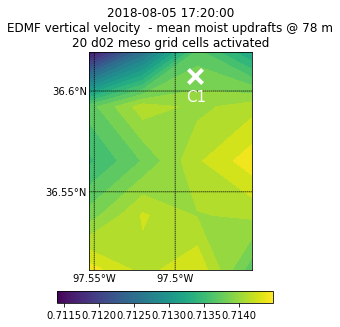

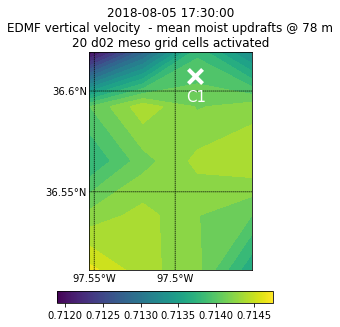

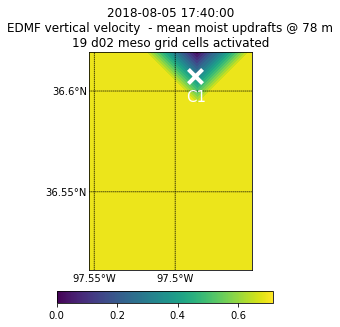

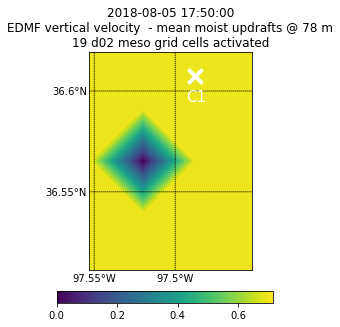

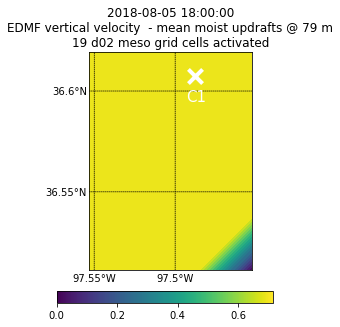

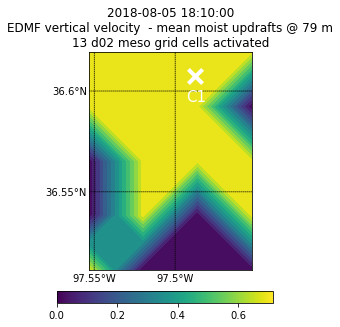

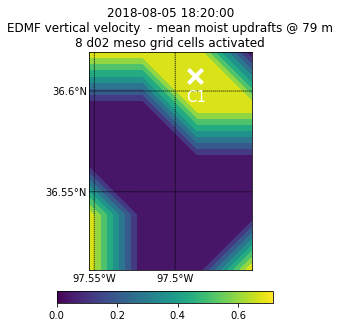

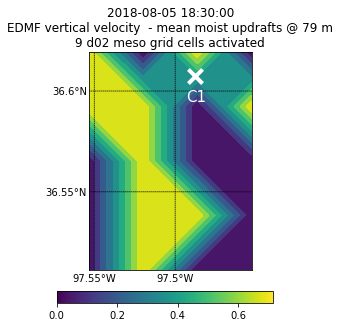

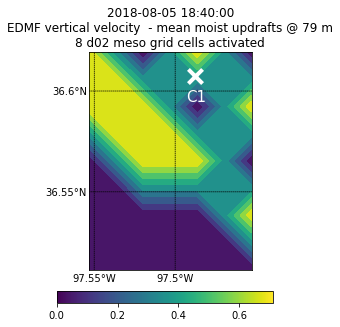

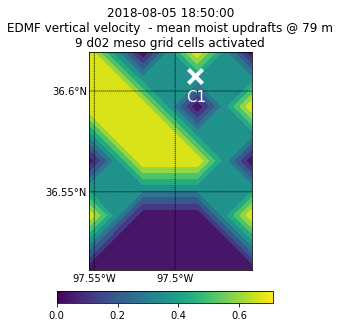

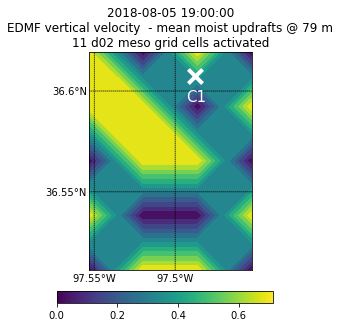

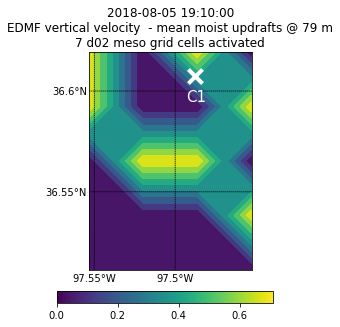

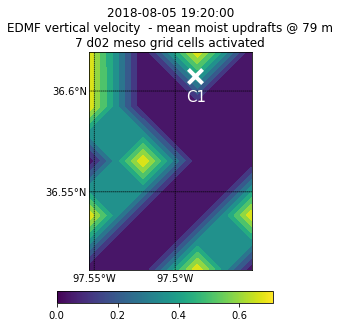

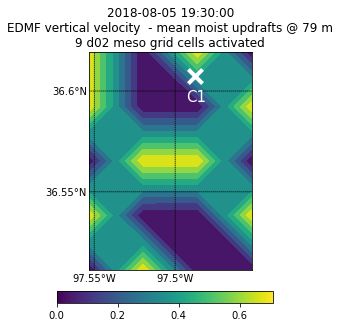

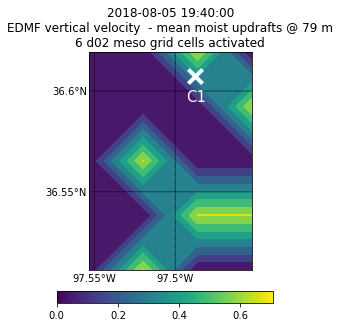

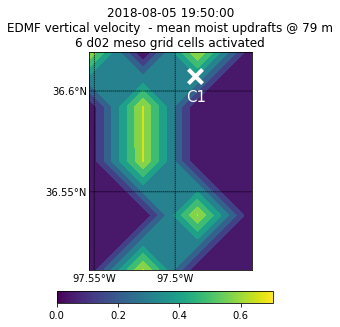

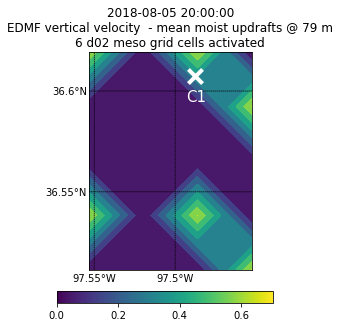

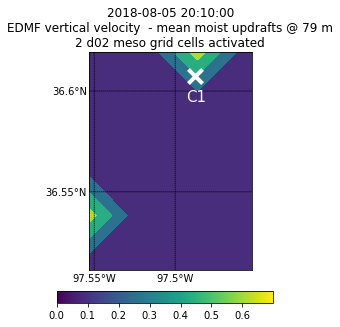

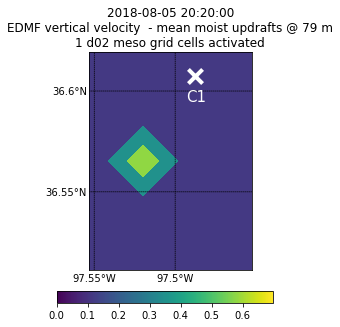

a total of 27 time steps w/ EDMF turned on in d02, they are:
['16:0', '16:10', '16:20', '16:30', '16:40', '16:50', '17:0', '17:10', '17:20', '17:30', '17:40', '17:50', '18:0', '18:10', '18:20', '18:30', '18:40', '18:50', '19:0', '19:10', '19:20', '19:30', '19:40', '19:50', '20:0', '20:10', '20:20']


In [79]:
eval_date = '2018-08-05'
run = 'edmf'
edmf_var = 'EDMF_W'
hgt_i = 16

detect_auxout_edmf_d02_plot_d04(eval_date, run, edmf_var, hgt_i)

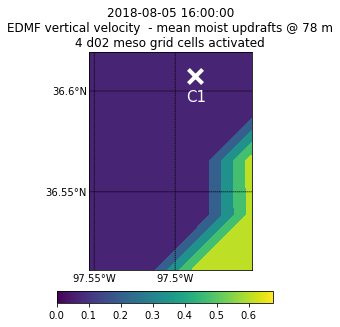

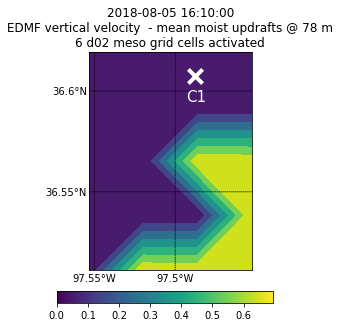

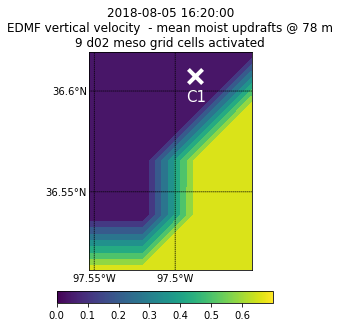

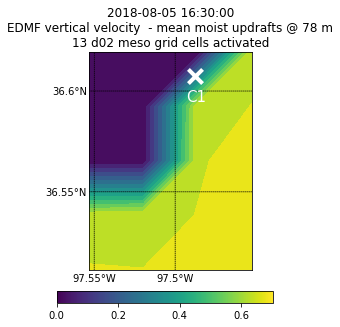

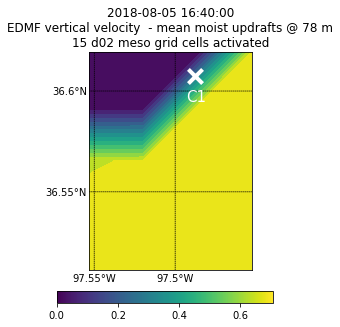

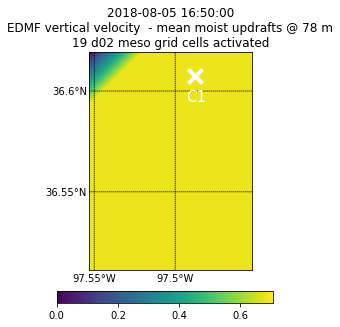

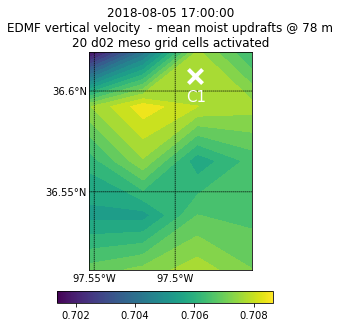

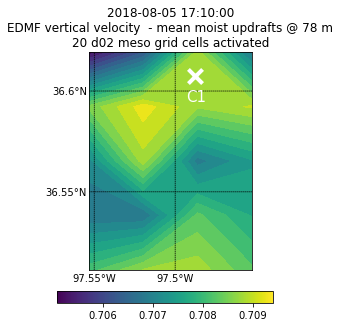

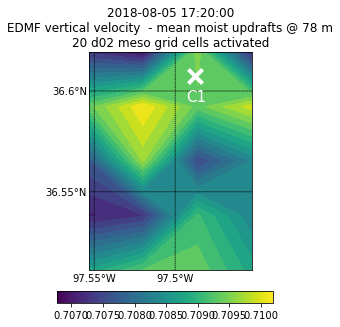

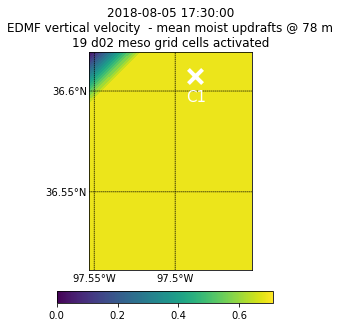

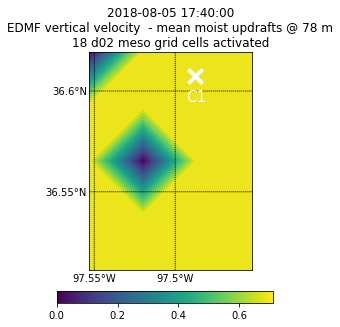

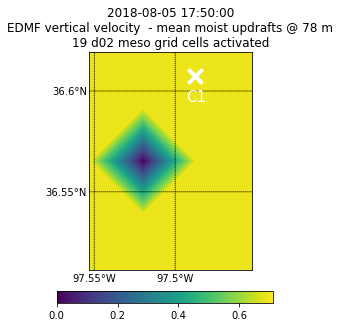

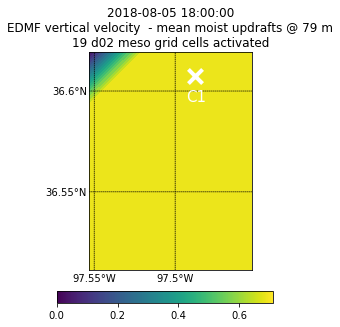

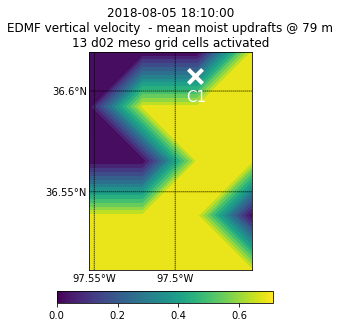

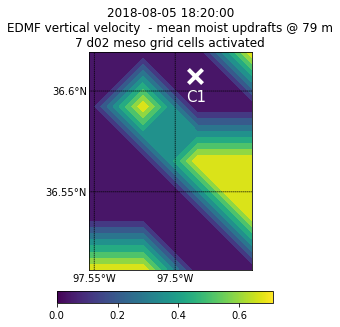

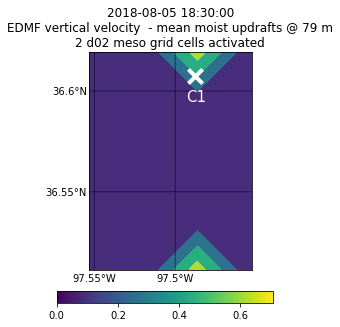

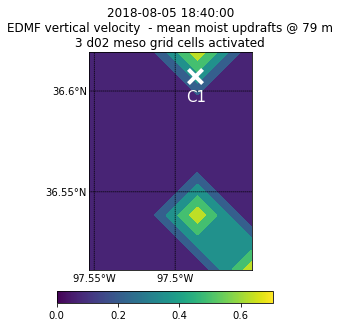

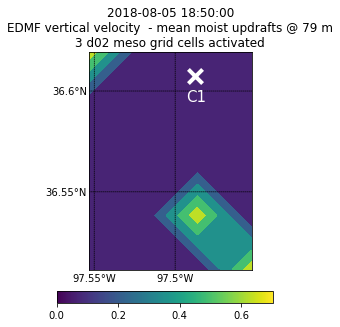

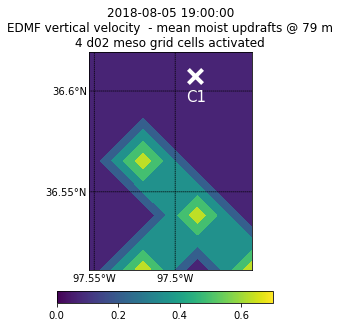

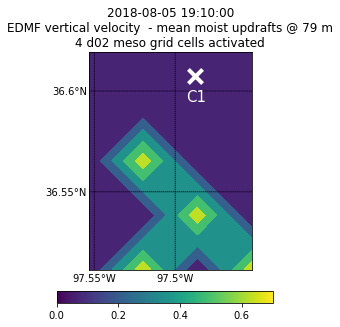

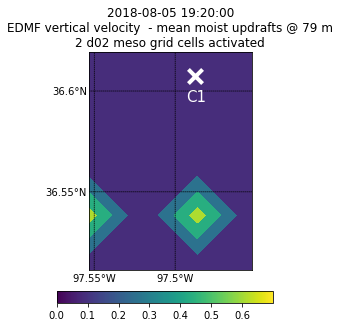

a total of 21 time steps w/ EDMF turned on in d02, they are:
['16:0', '16:10', '16:20', '16:30', '16:40', '16:50', '17:0', '17:10', '17:20', '17:30', '17:40', '17:50', '18:0', '18:10', '18:20', '18:30', '18:40', '18:50', '19:0', '19:10', '19:20']


In [80]:
eval_date = '2018-08-05'
run = 'edmf_d12-9s_d34-1s'
edmf_var = 'EDMF_W'
hgt_i = 16

detect_auxout_edmf_d02_plot_d04(eval_date, run, edmf_var, hgt_i)

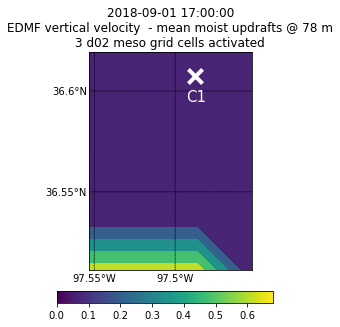

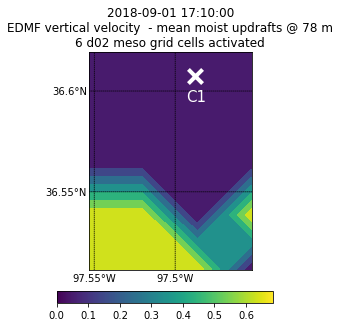

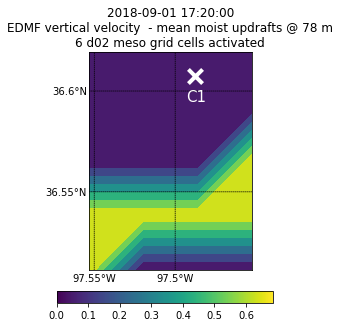

In [40]:
eval_date = '2018-09-01'
run = 'edmf'

date_col = data_dir_df[eval_date]
    
# hr = 20

for ind, hr in enumerate(np.arange(16, 24, 1)): 

    file = wrf_runs_dir+date_col[run]+'/auxout/mmc_d02_'+eval_date+'_'+str(hr)+':00:00'
    wrf_single = Dataset(file, 'r')

    var = wrf.getvar(wrf_single, 'EDMF_W', timeidx=wrf.ALL_TIMES)

    # d04 grid cells in d02
    var_w = var[:, :, 121:126, 119:123]
    
#     print(hr,'UTC')
    
    for t in np.arange(0, 6): 
        
        if (var_w[t, 16, :, :] != 0).sum().values != 0:
            
            hgt_i = 16
            
#             print(var_w[t, :, :, :].Time.values)
#             print((var_w[t, hgt_i, :, :] != 0).sum().values)
            
            height = wrf.getvar(wrf_single, 'height_agl').mean(dim=['south_north', 'west_east'])[hgt_i]
            height_str = str(int(height.values))
            
#             print(height_str)
            
            lats, lons = wrf.latlon_coords(var_w)

            fig, ax = plt.subplots()#figsize=(8, 8))
            
            var_1time1hgt = var_w[t, 16, :, :]
            
            bm = wrf.get_basemap(var_1time1hgt, ax=ax)

            bm.drawparallels(np.arange(36, 37, 0.05), labels=[1, 0, 0, 0])
            bm.drawmeridians(np.arange(-98, -97, 0.05), labels=[0, 0, 0, 1])

            x, y = bm(wrf.to_np(lons), wrf.to_np(lats))

            p = bm.contourf(x, y, wrf.to_np(var_1time1hgt), cmap=get_cmap('viridis'), 
                            levels=len(np.unique(var_1time1hgt.values)))
            
#             print(np.unique(var_1time1hgt.values))

            ax.set_title(str(pd.Timestamp(var_w[t, :, :, :].Time.values))+'\n'
                         +var_1time1hgt.description+' @ '+height_str+' m\n'
                         +str((var_w[t, hgt_i, :, :] != 0).sum().values)+' d02 meso grid cells activated')

            c1x, c1y = bm(wrf.to_np(-97.487643), wrf.to_np(36.607322))
            bm.scatter(c1x, c1y, s=200, marker='x', color='white', linewidth=4, ax=ax)

            c1x, c1y = bm(wrf.to_np(-97.493), wrf.to_np(36.595))
            ax.annotate('C1', xy=(c1x, c1y), size=15, color='white')
            
            cax = plt.axes([0.25, 0.01, 0.5, 0.04])
            sm = plt.cm.ScalarMappable(cmap='viridis', 
                                       norm=plt.Normalize(vmin=var_1time1hgt.min(), vmax=var_1time1hgt.max()))
            cb = plt.colorbar(sm, cax=cax, orientation='horizontal')
            
            plt.show()

In [23]:
var_1time

<xarray.DataArray 'EDMF_A' (south_north: 5, west_east: 4)>
array([[0.09847245, 0.        , 0.        , 0.        ],
       [0.09844768, 0.09846354, 0.09834101, 0.09849194],
       [0.        , 0.        , 0.        , 0.09847614],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -97.55 -97.52 ... -97.49 -97.45
    XLAT     (south_north, west_east) float32 36.51 36.51 36.51 ... 36.62 36.62
    XTIME    float32 1.76e+03
    Time     datetime64[ns] 2018-09-01T17:20:00
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  EDMF relative updraft  area - moist updrafts
    units:        -
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.48758697509766, moad_cen_lat...

In [16]:
str(pd.Timestamp(var_w[t, :, :, :].Time.values))

'2018-09-01 17:00:00'

In [5]:
eval_date = '2018-09-01'
run = 'edmf_d12-9s_d34-1s'

date_col = data_dir_df[eval_date]
    
hr = 20

for ind, hr in enumerate(np.arange(16, 24, 1)): 

    file = wrf_runs_dir+date_col[run]+'/auxout/mmc_d02_'+eval_date+'_'+str(hr)+':00:00'
    wrf_single = Dataset(file, 'r')

    var = wrf.getvar(wrf_single, 'EDMF_W', timeidx=wrf.ALL_TIMES)

    # d04 grid cells in d02
    var_w = var[:, :, 121:126, 119:123]
    
#     print(hr,'UTC')
    
    for t in np.arange(0, 6): 
        if (var_w[t, 16, :, :] != 0).sum().values != 0:
            print(var_w[t, :, :, :].Time.values)
            print((var_w[t, 16, :, :] != 0).sum().values)

2018-09-01T16:00:00.000000000
1
2018-09-01T16:10:00.000000000
1
2018-09-01T16:20:00.000000000
3
2018-09-01T16:30:00.000000000
2
2018-09-01T16:40:00.000000000
1
2018-09-01T16:50:00.000000000
2
2018-09-01T17:00:00.000000000
1


In [199]:
eval_date = '2018-09-01'
run = 'edmf_d12-9s_d34-1s'

date_col = data_dir_df[eval_date]
    
hr = 20

for ind, hr in enumerate(np.arange(16, 24, 1)): 

    file = wrf_runs_dir+date_col[run]+'/auxout/mmc_d02_'+eval_date+'_'+str(hr)+':00:00'
    wrf_single = Dataset(file, 'r')

    var = wrf.getvar(wrf_single, 'EDMF_A', timeidx=wrf.ALL_TIMES)

    # d04 grid cells in d02
    var_w = var[:, :, 121:126, 119:123]
    
    print(hr,'UTC')
    print((var_w[:, 20, :, :] != 0).sum().values)

16 UTC
10
17 UTC
1
18 UTC
0
19 UTC
0
20 UTC
0
21 UTC
0
22 UTC
0
23 UTC
0


In [197]:
eval_date = '2018-09-01'
run = 'edmf_d12-9s_d34-1s'

date_col = data_dir_df[eval_date]
    
hr = 20

for ind, hr in enumerate(np.arange(16, 24, 1)): 

    file = wrf_runs_dir+date_col[run]+'/auxout/mmc_d02_'+eval_date+'_'+str(hr)+':00:00'
    wrf_single = Dataset(file, 'r')

    var = wrf.getvar(wrf_single, 'EDMF_A', timeidx=wrf.ALL_TIMES)

    # d04 grid cells in d02
    var_w = var[:, :, 121:126, 119:123]
    
    print(hr,'UTC')
    print((var_w[:, 16, :, :] != 0).sum().values)

16 UTC
10
17 UTC
1
18 UTC
0
19 UTC
0
20 UTC
0
21 UTC
0
22 UTC
0
23 UTC
0


In [205]:
var_w[1, :, :, :].Time.values

numpy.datetime64('2018-09-01T23:10:00.000000000')

In [22]:
var.XLAT[115:133, :]

<xarray.DataArray 'XLAT' (south_north: 18, west_east: 220)>
array([[36.28063 , 36.28176 , 36.28287 , ..., 36.306057, 36.305145,
        36.30422 ],
       [36.307575, 36.308716, 36.309837, ..., 36.33302 , 36.33212 ,
        36.331192],
       [36.334534, 36.33567 , 36.3368  , ..., 36.35998 , 36.359074,
        36.358162],
       ...,
       [36.68502 , 36.68616 , 36.687286, ..., 36.71058 , 36.709663,
        36.70874 ],
       [36.71198 , 36.71311 , 36.714245, ..., 36.737553, 36.736637,
        36.735714],
       [36.738937, 36.740078, 36.741203, ..., 36.76451 , 36.7636  ,
        36.762676]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -101.5 -101.5 ... -94.22 -94.18
    XLAT     (south_north, west_east) float32 36.28 36.28 36.28 ... 36.76 36.76
Dimensions without coordinates: south_north, west_east

In [8]:
var

<xarray.DataArray 'EDMF_W' (Time: 6, bottom_top: 108, south_north: 220, west_east: 220)>
array([[[[0.        , 0.        , 0.24901947, ..., 0.        ,
          0.        , 0.        ],
         [0.24901946, 0.24901944, 0.        , ..., 0.        ,
          0.21707347, 0.        ],
         [0.24901947, 0.24901947, 0.24901946, ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.24901944, ..., 0.        ,
          0.        , 0.        ],
         [0.06113675, 0.07132042, 0.        , ..., 0.        ,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.27806658, ..., 0.        ,
          0.        , 0.        ],
         [0.2778025 , 0.27746004, 0.        , ..., 0.        ,
          0.24092576, 0.        ],
         [0.27774593, 0.27741912, 0.2776133 , ..., 0.        ,
          0.        , 0.        ],
...
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]]]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -101.4 -101.3 ... -94.12 -94.08
    XLAT     (south_north, west_east) float32 33.18 33.18 33.18 ... 39.11 39.11
    XTIME    (Time) float32 1.8e+03 1.81e+03 1.82e+03 1.83e+03 1.84e+03 1.85e+03
  * Time     (Time) datetime64[ns] 2018-09-01T18:00:00 ... 2018-09-01T18:50:00
Dimensions without coordinates: bottom_top, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  EDMF vertical velocity  - mean moist updrafts
    units:        m s-1
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.48758697509766, moad_cen_lat...

In [9]:
filed4 = wrf_runs_dir+date_col[run]+'/auxout/mmc_d04_'+eval_date+'_'+str(hr)+':00:00'
wrf_singled4 = Dataset(filed4, 'r')

In [11]:
hfxd4 = wrf.getvar(wrf_singled4, 'HFX', timeidx=wrf.ALL_TIMES)

In [15]:
hfxd4.XLAT.max(), hfxd4.XLAT.min()

(<xarray.DataArray 'XLAT' ()>
 array(36.62898254),
 <xarray.DataArray 'XLAT' ()>
 array(36.51060104))

In [16]:
hfxd4.XLONG.max(), hfxd4.XLONG.min()

(<xarray.DataArray 'XLONG' ()>
 array(-97.44958496),
 <xarray.DataArray 'XLONG' ()>
 array(-97.53878784))

In [91]:
filed3 = wrf_runs_dir+date_col[run]+'/auxout/mmc_d03_'+eval_date+'_'+str(hr)+':00:00'
wrf_singled3 = Dataset(filed3, 'r')

hfxd3 = wrf.getvar(wrf_singled3, 'HFX', timeidx=wrf.ALL_TIMES)[:, 158:223, 89:129]

In [92]:
hfxd3.XLAT.max(), hfxd3.XLAT.min()

(<xarray.DataArray 'XLAT' ()>
 array(36.6282692),
 <xarray.DataArray 'XLAT' ()>
 array(36.51312256))

In [93]:
hfxd3.XLONG.max(), hfxd3.XLONG.min()

(<xarray.DataArray 'XLONG' ()>
 array(-97.45046997),
 <xarray.DataArray 'XLONG' ()>
 array(-97.53787231))

In [134]:
var_w = var[:, :, 122:126, 119:123]

In [135]:
var_w.XLAT.max(), var_w.XLAT.min()

(<xarray.DataArray 'XLAT' ()>
 array(36.61926651),
 <xarray.DataArray 'XLAT' ()>
 array(36.53829193))

In [136]:
var_w.XLONG.max(), var_w.XLONG.min()

(<xarray.DataArray 'XLONG' ()>
 array(-97.45269775),
 <xarray.DataArray 'XLONG' ()>
 array(-97.55358887))

In [165]:
var_w = var[:, :, 121:126, 119:123]

In [166]:
var_w.XLAT.max(), var_w.XLAT.min()

(<xarray.DataArray 'XLAT' ()>
 array(36.61926651),
 <xarray.DataArray 'XLAT' ()>
 array(36.51131058))

In [167]:
var_w.XLONG.max(), var_w.XLONG.min()

(<xarray.DataArray 'XLONG' ()>
 array(-97.45269775),
 <xarray.DataArray 'XLONG' ()>
 array(-97.55358887))

In [169]:
var_w[:, 0, :, :]

<xarray.DataArray 'EDMF_W' (Time: 6, south_north: 5, west_east: 4)>
array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -97.55 -97.52 ... -97.49 -97.45
    XLAT     (south_north, west_east) float32 36.51 36.51 36.51 ... 36.62 36.62
    XTIME    (Time) float32 1.8e+03 1.81e+03 1.82e+03 1.83e+03 1.84e+03 1.85e+03
  * Time     (Time) datetime64[ns] 2018-09-01T18:00:00 ... 2018-09-01T18:50:00
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  EDMF vertical velocity  - mean moist updrafts
    units:        m s-1
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.48758697509766, moad_cen_lat...